
Training and Evaluating: XGBoost
Classification Report:
              precision    recall  f1-score   support

           0     0.9785    0.9887    0.9836     18600
           1     0.9936    0.9877    0.9906     32935

    accuracy                         0.9881     51535
   macro avg     0.9860    0.9882    0.9871     51535
weighted avg     0.9881    0.9881    0.9881     51535



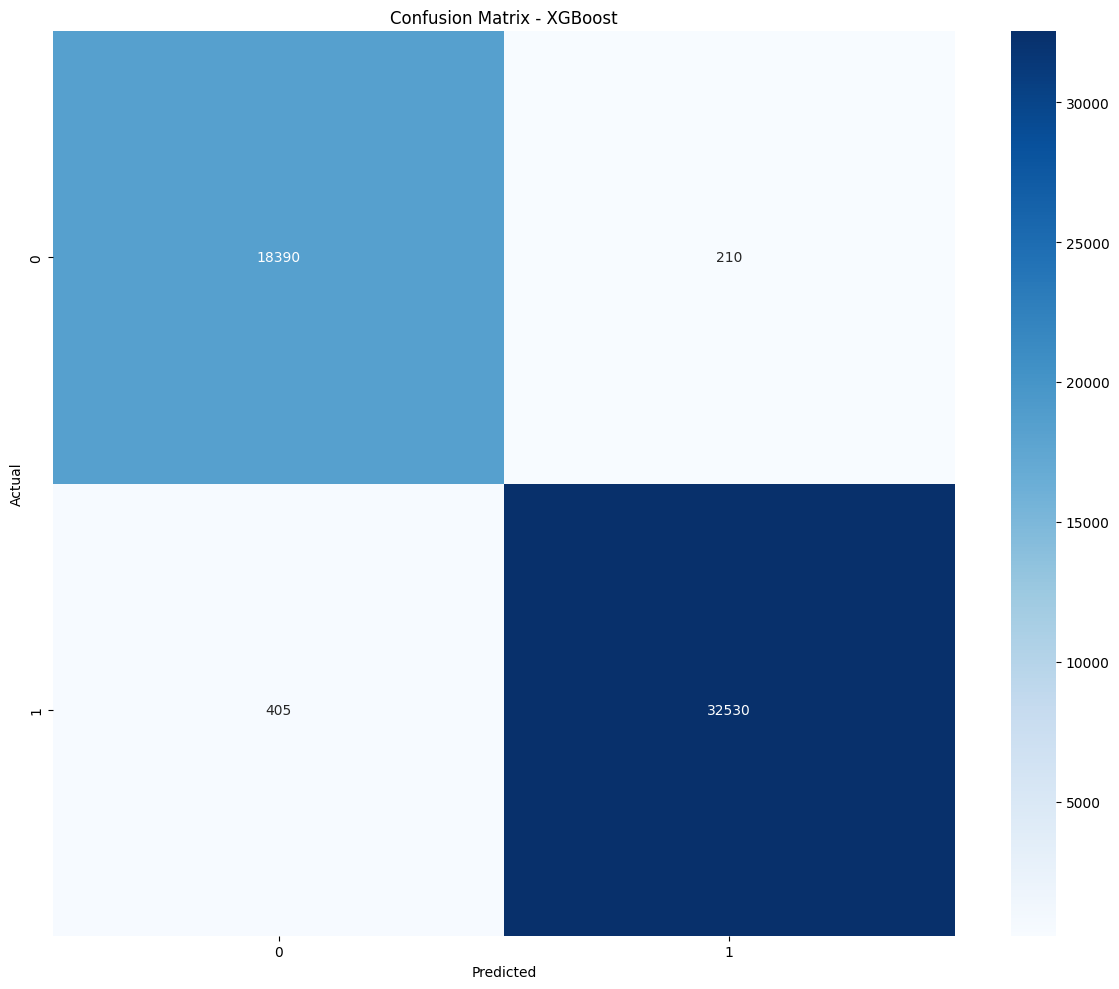


Training and Evaluating: LightGBM
[LightGBM] [Info] Number of positive: 131738, number of negative: 74400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6293
[LightGBM] [Info] Number of data points in the train set: 206138, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639077 -> initscore=0.571359
[LightGBM] [Info] Start training from score 0.571359
Classification Report:
              precision    recall  f1-score   support

           0     0.9723    0.9844    0.9783     18600
           1     0.9911    0.9842    0.9876     32935

    accuracy                         0.9843     51535
   macro avg     0.9817    0.9843    0.9830     51535
weighted avg     0.9843    0.9843    0.9843     51535



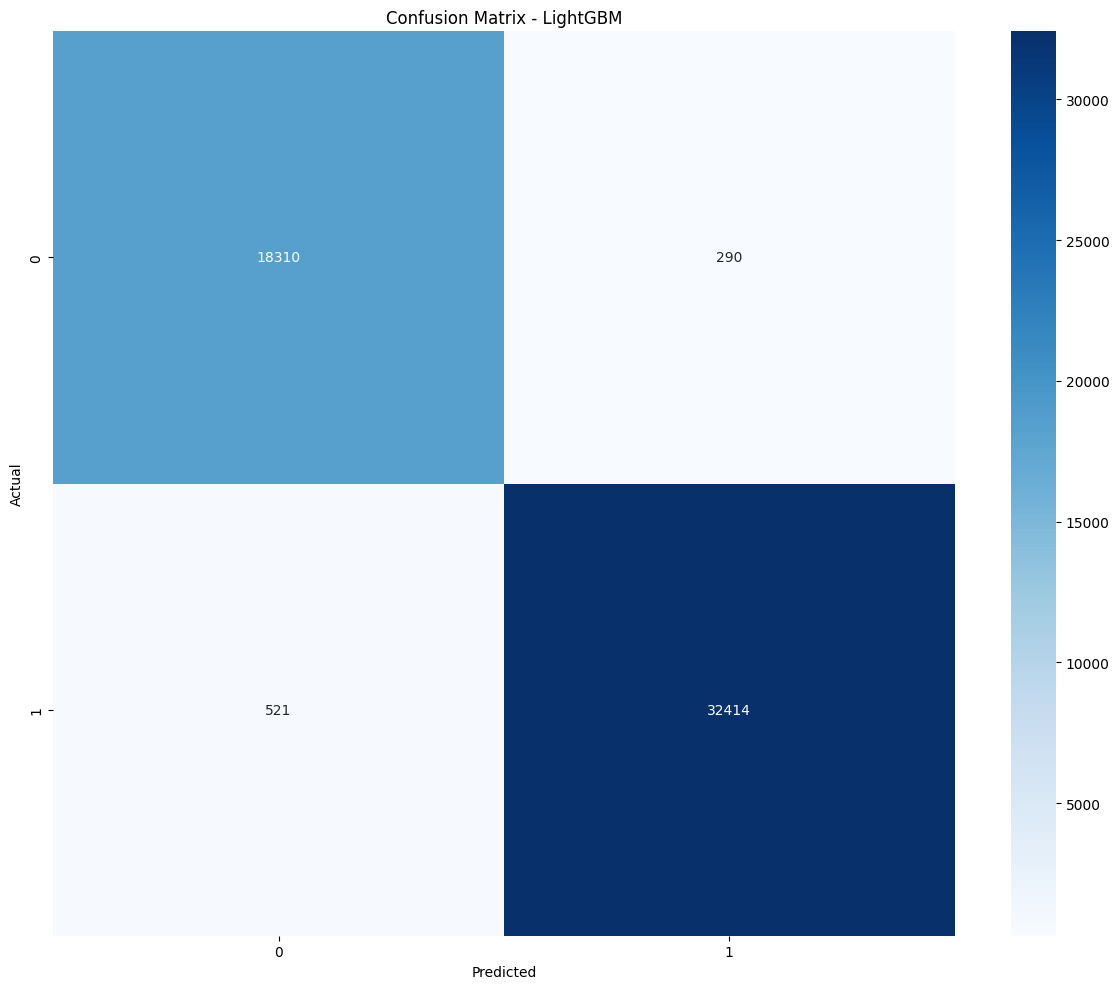


Training and Evaluating: CatBoost
Classification Report:
              precision    recall  f1-score   support

           0     0.9800    0.9898    0.9849     18600
           1     0.9942    0.9886    0.9914     32935

    accuracy                         0.9890     51535
   macro avg     0.9871    0.9892    0.9881     51535
weighted avg     0.9891    0.9890    0.9890     51535



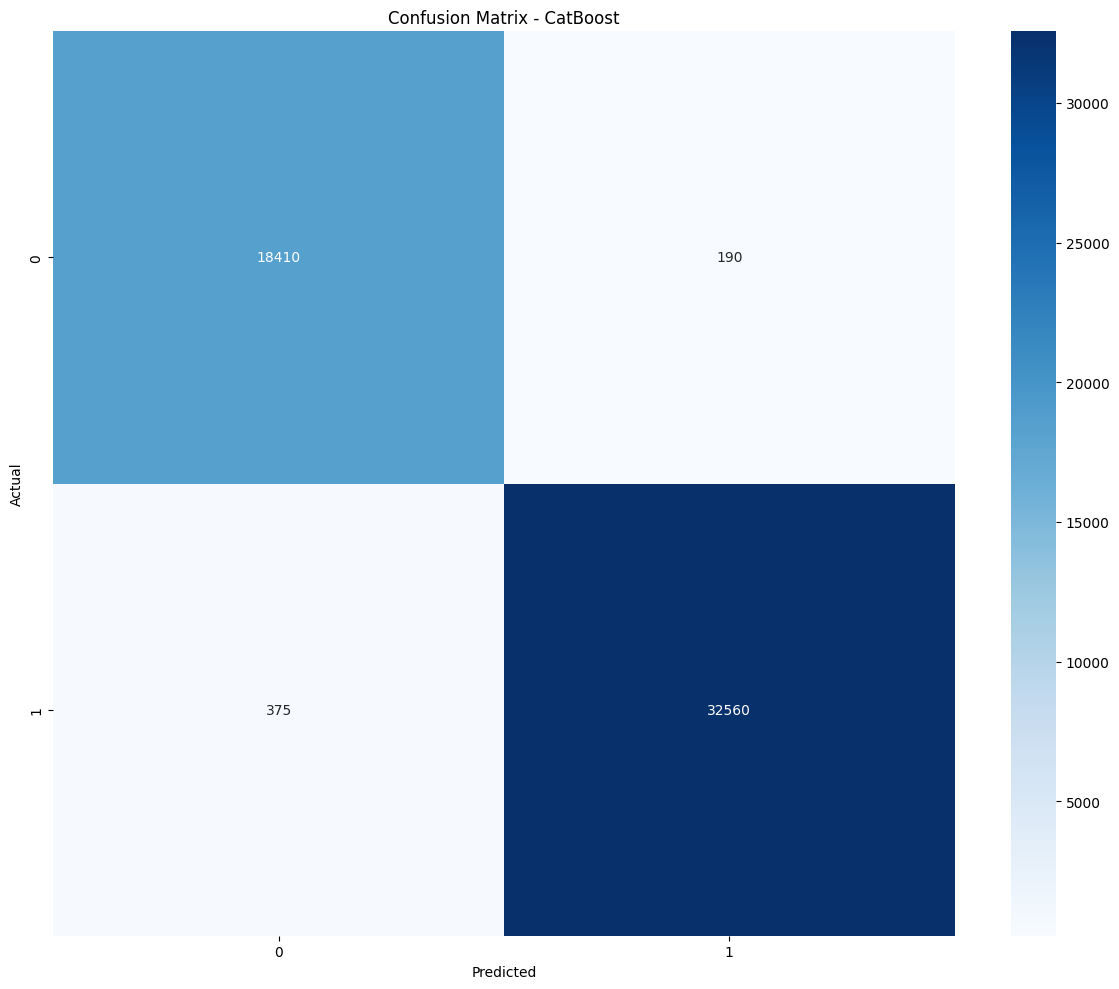


Training and Evaluating: AdaBoost
Classification Report:
              precision    recall  f1-score   support

           0     0.9455    0.9505    0.9480     18600
           1     0.9720    0.9691    0.9705     32935

    accuracy                         0.9624     51535
   macro avg     0.9587    0.9598    0.9592     51535
weighted avg     0.9624    0.9624    0.9624     51535



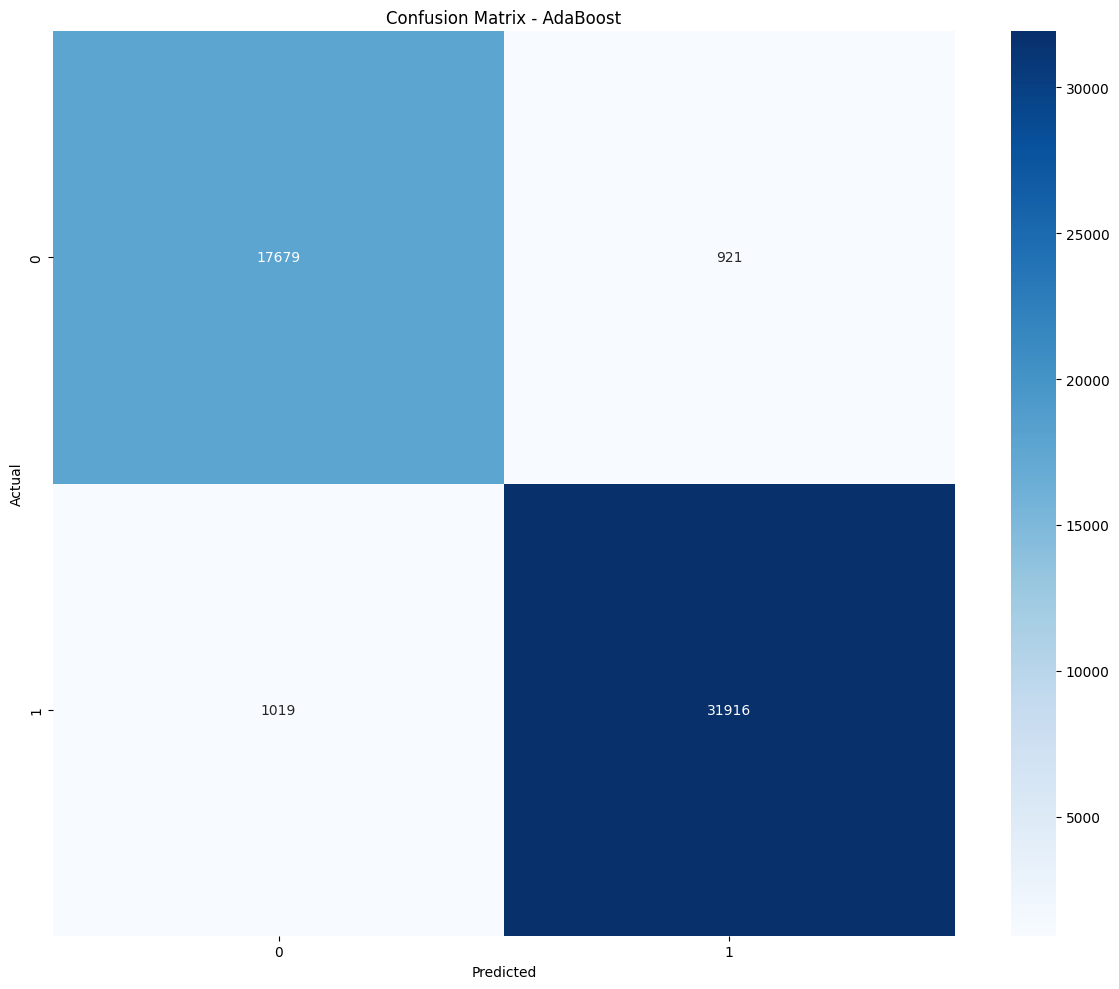


Training and Evaluating: ExtraTrees
Classification Report:
              precision    recall  f1-score   support

           0     0.9707    0.9704    0.9705     18600
           1     0.9833    0.9835    0.9834     32935

    accuracy                         0.9787     51535
   macro avg     0.9770    0.9769    0.9769     51535
weighted avg     0.9787    0.9787    0.9787     51535



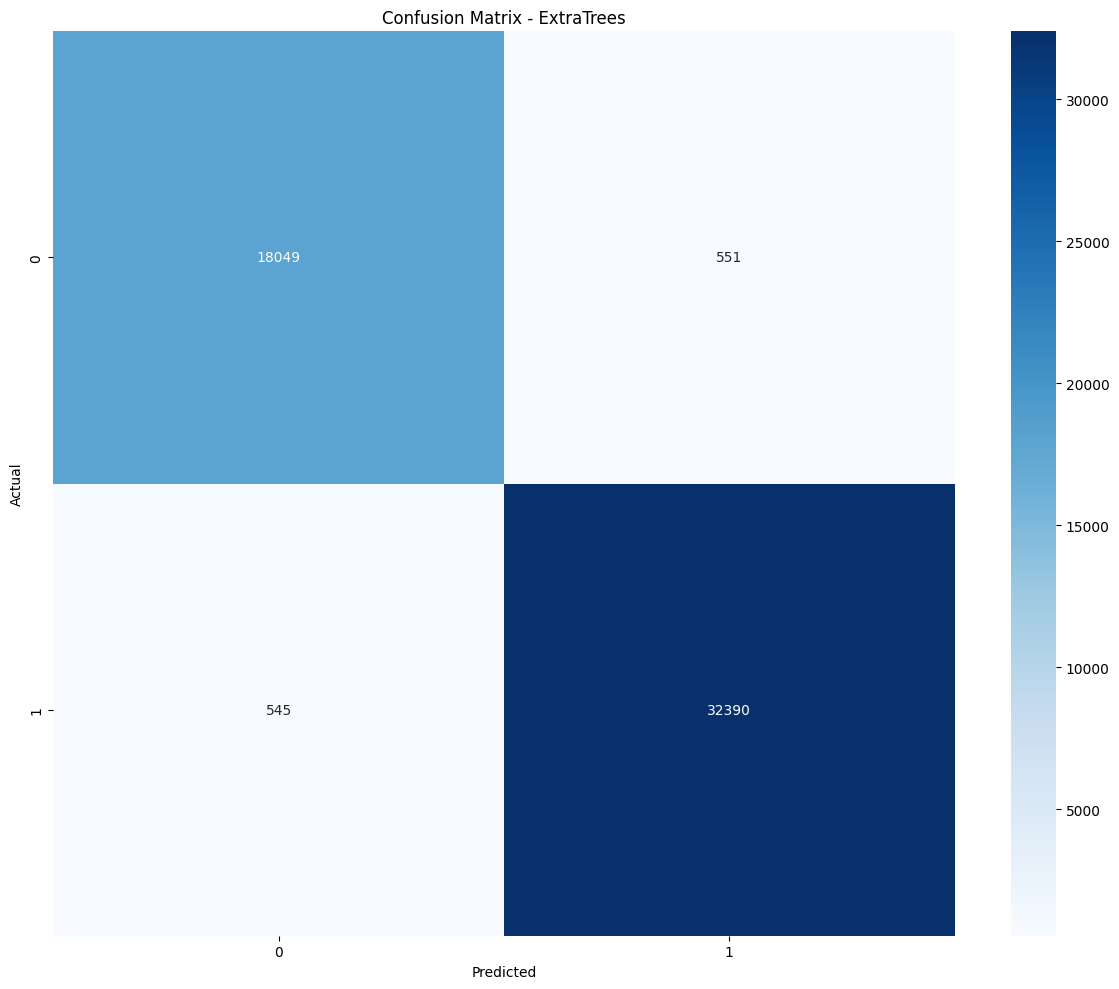


===== Ensemble Model Performance Comparison =====
     Model  Accuracy  Precision   Recall  F1-Score
  CatBoost  0.989037   0.987118 0.989199  0.988143
   XGBoost  0.988066   0.986019 0.988206  0.987095
  LightGBM  0.984263   0.981733 0.984295  0.982989
ExtraTrees  0.978733   0.976981 0.976914  0.976948
  AdaBoost  0.962356   0.958727 0.959772  0.959245


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier

# Load dataset
path_train = "../../Data/unsw-nb2015/UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_training-set.csv"
path_test = "../../Data/unsw-nb2015/UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_testing-set.csv"

df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)
df = pd.concat([df_train, df_test], ignore_index=True)

# Encode categorical columns
categorical_cols = ['proto', 'service', 'state']
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Encode target
le_target = LabelEncoder()
df['label'] = le_target.fit_transform(df['label'].astype(str))

# Prepare features and target
X = df.drop(columns=['attack_cat', 'label'])
y = df['label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Define models
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42)
}

results = []

for name, model in models.items():
    print(f"\nTraining and Evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_test_named = le_target.inverse_transform(y_test)
    y_pred_named = le_target.inverse_transform(y_pred)

    acc = accuracy_score(y_test_named, y_pred_named)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_named, y_pred_named, average='macro')

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

    print("Classification Report:")
    print(classification_report(y_test_named, y_pred_named, digits=4))

    cm = confusion_matrix(y_test_named, y_pred_named, labels=le_target.classes_)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Display comparison table
results_df = pd.DataFrame(results)
print("\n===== Ensemble Model Performance Comparison =====")
print(results_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))

# Optional: save table to CSV
results_df.to_csv("ensemble_model_performance.csv", index=False)
